In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import glob
import sys
from tqdm import tqdm
 
# Get the absolute path of the directory where the notebook is running
notebook_dir = os.getcwd()
module_path = os.path.abspath(os.path.join(notebook_dir, '..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from model.model import ChessResNet
from model.train import ChessDataset
import matplotlib.pyplot as plt
from IPython import display

In [2]:
TRAIN_DIR = "../data/torch/train" # Directory where your .pt files are
TEST_DIR = "../data/torch/test" 
VAL_DIR = "../data/torch/val" 
EPOCHS = 300
BATCH_SIZE = 512
LEARNING_RATE = 0.01

torch.multiprocessing.freeze_support()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if not os.path.exists(TRAIN_DIR):
    print(f"Error: Data directory '{TRAIN_DIR}' not found.")
    print("Please create it and run process_pgn_directory.py first.")
    raise(ValueError)
        
dataset = ChessDataset(data_directory=TRAIN_DIR, samples_per_epoch=500000)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

test_dataset = ChessDataset(data_directory=TEST_DIR, samples_per_epoch=50000)
test_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    
    # --- Model, Loss, and Optimizer ---
model = ChessResNet().to(device)
policy_loss_fn = nn.CrossEntropyLoss()
value_loss_fn = nn.MSELoss()#nn.SmoothL1Loss()#
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

print("--- Starting Training ---")
    


Using device: cuda
Found 404 data files. Loading into memory...


Loading data files:  12%|█▏        | 49/404 [00:09<01:10,  5.07it/s]


Total positions loaded: 500000
Found 22 data files. Loading into memory...


Loading data files:  18%|█▊        | 4/22 [00:01<00:05,  3.52it/s]


Total positions loaded: 50000
--- Starting Training ---


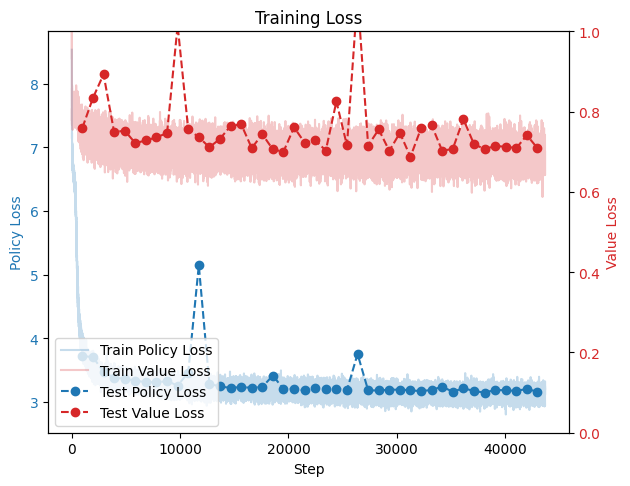

Epoch 45/300: 767it [06:13,  2.05it/s]


KeyboardInterrupt: 

In [4]:
# Lists to store every batch loss for training
train_policy_batch_losses = []
train_value_batch_losses = []

# Lists to store average epoch loss for testing
test_policy_epoch_losses = []
test_value_epoch_losses = []
test_plot_steps = [] # X-axis coordinates for test plots

for epoch in range(EPOCHS):
    model.train() # Set model to training mode
            
    # Use tqdm for a progress bar over the batches
    for n,batch in tqdm(enumerate(dataloader), desc=f"Epoch {epoch+1}/{EPOCHS}"):
        # 1. Get data and move to device
        states, target_policies, target_values = batch
        states = states.to(device)
        target_policies = target_policies.to(device)
        target_values = target_values.to(device)
        
        # 2. Forward pass
        pred_policies, pred_values = model(states)

        # print(pred_values.squeeze(), target_values) # Optional: uncomment for debugging
        
        # 3. Calculate loss
        policy_loss = policy_loss_fn(pred_policies, target_policies)
        value_loss = value_loss_fn(pred_values.squeeze(), target_values)
        total_loss = policy_loss*0.1 + value_loss 
        
        # 4. Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # Append batch losses
        train_policy_batch_losses.append(policy_loss.item())
        train_value_batch_losses.append(value_loss.item())

        # Update plot every 100 steps
        if n % 100 == 0:
            display.clear_output(wait=True)
            fig, ax1 = plt.subplots()
            
            color1 = 'tab:blue'
            ax1.set_xlabel('Step')
            ax1.set_ylabel('Policy Loss', color=color1)
            # Plot all training batch losses
            line1 = ax1.plot(train_policy_batch_losses, color=color1, label='Train Policy Loss', alpha=0.25)[0]
            ax1.tick_params(axis='y', labelcolor=color1)

            ax2 = ax1.twinx()

            color2 = 'tab:red'
            ax2.set_ylabel('Value Loss', color=color2)
            # Plot all training batch losses
            line2 = ax2.plot(train_value_batch_losses, color=color2, label='Train Value Loss', alpha=0.25)[0]
            ax2.tick_params(axis='y', labelcolor=color2)
            ax2.set_ylim(0,1)

            lines = [line1, line2]

            # Plot test losses if they exist (after epoch 1)
            if test_plot_steps:
                line3 = ax1.plot(test_plot_steps, test_policy_epoch_losses, color=color1, linestyle='--', marker='o', label='Test Policy Loss')[0]
                line4 = ax2.plot(test_plot_steps, test_value_epoch_losses, color=color2, linestyle='--', marker='o', label='Test Value Loss')[0]
                lines.extend([line3, line4])

            ax1.legend(handles=lines, loc='lower left')

            fig.tight_layout()
            plt.title("Training Loss")
            plt.savefig("training.png", dpi=300)
            plt.show()
            
            plt.pause(0.01)
        
    # --- Start of Epoch Testing (runs once at the end of the epoch) ---
    model.eval() 
    running_test_policy_loss = 0.0
    running_test_value_loss = 0.0
    
    with torch.no_grad(): 
        for batch in test_dataloader:
            states, target_policies, target_values = batch
            states = states.to(device)
            target_policies = target_policies.to(device)
            target_values = target_values.to(device)
            
            pred_policies, pred_values = model(states)
            
            policy_loss = policy_loss_fn(pred_policies, target_policies)
            value_loss = value_loss_fn(pred_values.squeeze(), target_values)
            
            running_test_policy_loss += policy_loss.item()
            running_test_value_loss += value_loss.item()
            
    # Store average test loss for this epoch
    test_policy_epoch_losses.append(running_test_policy_loss / len(test_dataloader))
    test_value_epoch_losses.append(running_test_value_loss / len(test_dataloader))
    # Store the global step count (x-axis) for this test point
    test_plot_steps.append(len(train_policy_batch_losses) - 1)
    # --- End of Epoch Testing ---

    dataset.resample()
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    test_dataset.resample()
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)


# --- End of Training ---
print("--- Training Complete ---")
    
# Save the trained model
model_save_path = "chess_resnet_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Trained model saved to: {model_save_path}")